# Quantum Computing Math Cheat Sheet

In [83]:
import numpy as np
import sympy as sym
from IPython.display import display, Math
import random
import matplotlib.pyplot as plt

In [84]:
sym.init_printing() # prety printing of math

## Subjects
- Complex numbers
- Complex numbers - Polar Form   
- Complex conjugate    
- Magnitude     
- Conjugate transpose   
- Inner product   
- Eucledian norm
- Unit vector
- Distance between vectors
- Orthonormal bases
- Computational (standard) basis

## Helper functions

In [85]:
# AngleAnnotation class
# from:
# https://matplotlib.org/stable/gallery/text_labels_and_annotations/angle_annotation.html#angleannotation-class

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from matplotlib.transforms import IdentityTransform, TransformedBbox, Bbox


class AngleAnnotation(Arc):
    """
    Draws an arc between two vectors which appears circular in display space.
    """
    def __init__(self, xy, p1, p2, size=75, unit="points", ax=None,
                 text="", textposition="inside", text_kw=None, **kwargs):
        """
        Parameters
        ----------
        xy, p1, p2 : tuple or array of two floats
            Center position and two points. Angle annotation is drawn between
            the two vectors connecting *p1* and *p2* with *xy*, respectively.
            Units are data coordinates.

        size : float
            Diameter of the angle annotation in units specified by *unit*.

        unit : str
            One of the following strings to specify the unit of *size*:

            * "pixels": pixels
            * "points": points, use points instead of pixels to not have a
              dependence on the DPI
            * "axes width", "axes height": relative units of Axes width, height
            * "axes min", "axes max": minimum or maximum of relative Axes
              width, height

        ax : `matplotlib.axes.Axes`
            The Axes to add the angle annotation to.

        text : str
            The text to mark the angle with.

        textposition : {"inside", "outside", "edge"}
            Whether to show the text in- or outside the arc. "edge" can be used
            for custom positions anchored at the arc's edge.

        text_kw : dict
            Dictionary of arguments passed to the Annotation.

        **kwargs
            Further parameters are passed to `matplotlib.patches.Arc`. Use this
            to specify, color, linewidth etc. of the arc.

        """
        self.ax = ax or plt.gca()
        self._xydata = xy  # in data coordinates
        self.vec1 = p1
        self.vec2 = p2
        self.size = size
        self.unit = unit
        self.textposition = textposition

        super().__init__(self._xydata, size, size, angle=0.0,
                         theta1=self.theta1, theta2=self.theta2, **kwargs)

        self.set_transform(IdentityTransform())
        self.ax.add_patch(self)

        self.kw = dict(ha="center", va="center",
                       xycoords=IdentityTransform(),
                       xytext=(0, 0), textcoords="offset points",
                       annotation_clip=True)
        self.kw.update(text_kw or {})
        self.text = ax.annotate(text, xy=self._center, **self.kw)

    def get_size(self):
        factor = 1.
        if self.unit == "points":
            factor = self.ax.figure.dpi / 72.
        elif self.unit[:4] == "axes":
            b = TransformedBbox(Bbox.unit(), self.ax.transAxes)
            dic = {"max": max(b.width, b.height),
                   "min": min(b.width, b.height),
                   "width": b.width, "height": b.height}
            factor = dic[self.unit[5:]]
        return self.size * factor

    def set_size(self, size):
        self.size = size

    def get_center_in_pixels(self):
        """return center in pixels"""
        return self.ax.transData.transform(self._xydata)

    def set_center(self, xy):
        """set center in data coordinates"""
        self._xydata = xy

    def get_theta(self, vec):
        vec_in_pixels = self.ax.transData.transform(vec) - self._center
        return np.rad2deg(np.arctan2(vec_in_pixels[1], vec_in_pixels[0]))

    def get_theta1(self):
        return self.get_theta(self.vec1)

    def get_theta2(self):
        return self.get_theta(self.vec2)

    def set_theta(self, angle):
        pass

    # Redefine attributes of the Arc to always give values in pixel space
    _center = property(get_center_in_pixels, set_center)
    theta1 = property(get_theta1, set_theta)
    theta2 = property(get_theta2, set_theta)
    width = property(get_size, set_size)
    height = property(get_size, set_size)

    # The following two methods are needed to update the text position.
    def draw(self, renderer):
        self.update_text()
        super().draw(renderer)

    def update_text(self):
        c = self._center
        s = self.get_size()
        angle_span = (self.theta2 - self.theta1) % 360
        angle = np.deg2rad(self.theta1 + angle_span / 2)
        r = s / 2
        if self.textposition == "inside":
            r = s / np.interp(angle_span, [60, 90, 135, 180],
                                          [3.3, 3.5, 3.8, 4])
        self.text.xy = c + r * np.array([np.cos(angle), np.sin(angle)])
        if self.textposition == "outside":
            def R90(a, r, w, h):
                if a < np.arctan(h/2/(r+w/2)):
                    return np.sqrt((r+w/2)**2 + (np.tan(a)*(r+w/2))**2)
                else:
                    c = np.sqrt((w/2)**2+(h/2)**2)
                    T = np.arcsin(c * np.cos(np.pi/2 - a + np.arcsin(h/2/c))/r)
                    xy = r * np.array([np.cos(a + T), np.sin(a + T)])
                    xy += np.array([w/2, h/2])
                    return np.sqrt(np.sum(xy**2))

            def R(a, r, w, h):
                aa = (a % (np.pi/4))*((a % (np.pi/2)) <= np.pi/4) + \
                     (np.pi/4 - (a % (np.pi/4)))*((a % (np.pi/2)) >= np.pi/4)
                return R90(aa, r, *[w, h][::int(np.sign(np.cos(2*a)))])

            bbox = self.text.get_window_extent()
            X = R(angle, r, bbox.width, bbox.height)
            trans = self.ax.figure.dpi_scale_trans.inverted()
            offs = trans.transform(((X-s/2), 0))[0] * 72
            self.text.set_position([offs*np.cos(angle), offs*np.sin(angle)])

In [86]:
# Complex plane
# from:
# https://github.com/osnove/other/blob/master/complex_plane.py
# with a few changes by me

import matplotlib.pyplot as plt
import numpy as np # dodamo še numerično knjižico 
get_ipython().run_line_magic('matplotlib', 'inline')


def complex_plane2(z,p1=None,p2=None,angle_size=0,center=(0,0),axis_type=0, angle_position="edge"):
    """Creates complex plane and shows complex numbers as vectors (complexors)
    
    Parameters
    ----------
    z : array of complex values
        array of complex values to be shown
    axis_type : int 
        three types of shapes of complex plane:
        0 : symple
        1 : with grid
        2 : moved axis to middle 
    -----------------------------------
    # Example
    z=[20+10j,15,-10-10j,5+15j]
    complex_plane2(z,2) """

    w=max(np.abs(z))
    fig, ax = plt.subplots()
        
    if axis_type==0: 
        plt.axis("off")
        plt.text(-0.15*w, 0.8*w, "i", fontsize=14)
        plt.text( 0.8*w,-0.15*w, "ℝ", fontsize=14)
        plt.text(-0.15*w, -0.9*w, "-i", fontsize=14)
        plt.text( -0.9*w,-0.15*w, '-ℝ', fontsize=14)
    elif axis_type==1: 
        plt.axis("on")
        plt.grid()
        plt.text(-0.15*w, 0.8*w, "i", fontsize=14)
        plt.text( 0.8*w,-0.15*w, 'ℝ', fontsize=14)
        plt.text(-0.15*w, -0.9*w, "-i", fontsize=14)
        plt.text( -0.9*w,-0.15*w, '-ℝ', fontsize=14)
    else:
         # Move left y-axis and bottim x-axis to centre, passing through (0,0)
        ax.spines['left'].set_position('center')
        ax.spines['bottom'].set_position('center')

        # Eliminate upper and right axes
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')

        # Show ticks in the left and lower axes only
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

        # ax.set_xlabel('                                                 ℝ')
        # ax.set_ylabel('                                                 i')
        plt.text(-0.15*w, 0.8*w, "i", fontsize=14)
        plt.text( 0.8*w,-0.15*w, 'ℝ', fontsize=14)

    plt.xlim(-w,w)
    plt.ylim(-w,w)
    plt.arrow(0, -w, 0, 1.9*w, head_width=w/20, head_length=w/20, fc='k', ec='k');
    plt.arrow(-w, 0, 1.9*w, 0, head_width=w/20, head_length=w/20, fc='k', ec='k');

    for i in range(len(z)):
        fi_a=np.angle(z[i])
        x=z[i].real -abs(w)/20*np.cos(fi_a)
        y=z[i].imag-abs(w)/20*np.sin(fi_a)
        plt.arrow(0, 0, x, y, head_width=w/20, head_length=w/20, fc='b', ec='b');
        
              
        # call AngleAnnotation func
        if p2 != None or p1 != None:
            point, = ax.plot(*center, marker="o")
            AngleAnnotation(center, p1[1], p2[1], ax=ax, size=angle_size, text=r"$\theta$", textposition=angle_position)
        

## Definitions

In [87]:
display( Math('a := expr \quad ==> \\textit{a} \\: \\text{is defined as the expression} \\: \\textit{expr}') )

<IPython.core.display.Math object>

## Complex numbers

In [88]:
display( Math('a,b \\in \\mathbb{R}') )
display( Math('c \\in \\mathbb{C}') )
display( Math('i := \\sqrt{-1}') )
display( Math('c = a + i \\cdot b') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [89]:
v= np.array(['𝜓_1','𝜓_2','𝜓_3','𝜓_d'])
v.shape = (4,1)
display( Math('| \\psi \\rangle = ' + sym.latex(sym.sympify(v)) + '\\in \\mathbb{C^d}') )
display( Math('\\psi_i \\in \\mathbb{C}') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Complex numbers - Polar Form

In [90]:
display( Math('r,\\theta \\in \\mathbb{R}') )
display( Math('c \\in \\mathbb{C}') )
display( Math('c = re^{i\\theta}') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

#### Geometric interpretation

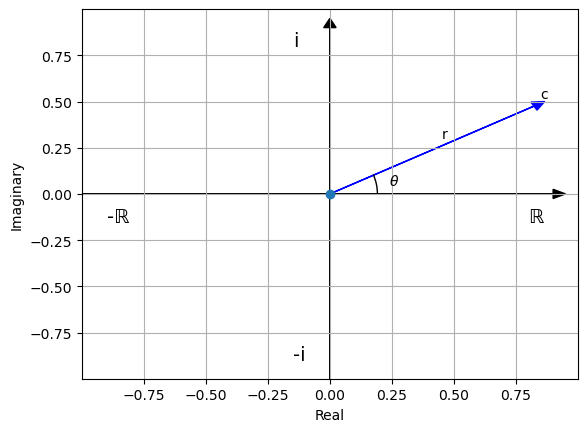

In [91]:
import matplotlib.pyplot as plt
import numpy as np # dodamo še numerično knjižico 
get_ipython().run_line_magic('matplotlib', 'inline')

# params for complex_plane2 func
z=[0.866+0.5j] # 𝜃 = 30

# params for AngleAnnotation func
center = (0, 0)
p1 = [(0, 0), (0, 0)]
p2 = [(0, 0), (0.3, 0.18)]
angle_size= 95

complex_plane2(z,p1,p2,angle_size,center,axis_type=1,angle_position="edge")
        
plt.ylabel('Imaginary')
plt.xlabel('Real')

plt.text(0.45,0.3,'r')
plt.text(0.85,0.52,'c')
plt.show()

In [92]:
display( Math('r,\\theta \\in \\mathbb{R}') )
display( Math('r = 1') )
display( Math('c = r \\cdot cos \\theta + r \\cdot i \\cdot sin \\theta = r(cos \\theta + i \\cdot sin \\theta)') )
display( Math("\\text{Euler's formula: } e^{i\\theta} = cos \\theta + i \\cdot sin \\theta") )
display( Math('c = re^{i\\theta}') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Samples

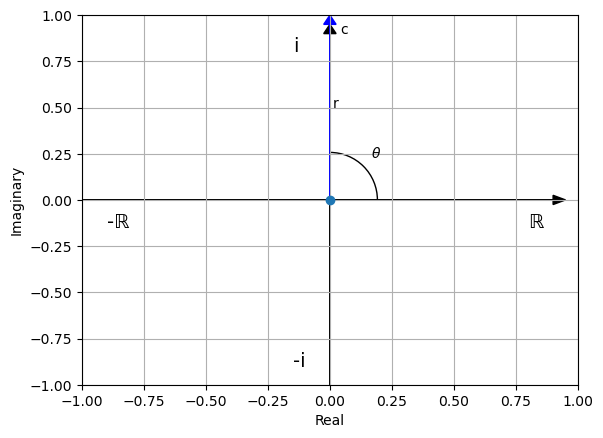

In [93]:
z=[0+1j] # 𝜃 = 𝜋/2

center = (0, 0)
p1 = [(0, 0), (30, 0)]
p2 = [(0, 0), (0, 30)]
angle_size= 95

complex_plane2(z,p1,p2,angle_size,center,axis_type=1,angle_position="edge")
        
plt.ylabel('Imaginary')
plt.xlabel('Real')

plt.text(0.01,0.5,'r')
plt.text(0.04,0.9,'c')
plt.show()

In [94]:
display( Math('\\text{imaginary numbers rule:} \\: e^{i \\cdot \\pi \\cdot x} = (-1)^x') )
display( Math('e^{i \\cdot \\frac {\\pi}{2}} = e^{i \\cdot \\pi \\cdot \\frac {1}{2}} = (-1)^\\frac {1}{2} = \\sqrt{-1} = i') )
display( Math('r = 1') )
display( Math('\\theta = \\frac {\\pi}{2}') )
display( Math('c = re^{i\\theta} = 1 \\cdot e^{i \\cdot \\frac {\\pi}{2}} = 1 \\cdot i = i = 0 + i \\cdot 1') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [95]:
display( Math('\\text{Validate using Pythagorean theorem:  } c = \\sqrt{a^2 + b^2 }') )
display( Math('r = \\sqrt{ (r \\cdot 𝑐𝑜𝑠\\theta)^2 + (r \\cdot sin\\theta)^2} = \
\\sqrt{ (1 \\cdot 𝑐𝑜𝑠(\\frac{\\pi}{2}))^2 + (1 \\cdot sin(\\frac{\\pi}{2}))^2 } = \\sqrt{ 0 + 1 } = 1' ) )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

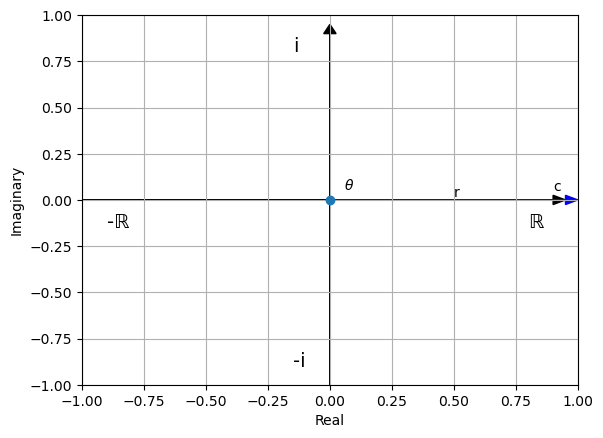

In [96]:
z=[1+0j]  # 𝜃 = 0

center = (0, 0)
p1 = [(0, 0), (1, 1)]
p2 = [(0, 0), (1, 1)]
angle_size= 35

complex_plane2(z,p1,p2,angle_size,center,axis_type=1,angle_position="edge")
        
plt.ylabel('Imaginary')
plt.xlabel('Real')

plt.text(0.5,0.02,'r')
plt.text(0.9,0.05,'c')
plt.show()

In [97]:
display( Math('r = 1') )
display( Math('\\theta = 0') )
display( Math('c = re^{i\\theta} = 1 \\cdot e^{i \\cdot 0} = 1 \\cdot 1 = 1 = 1 + i \\cdot 0') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

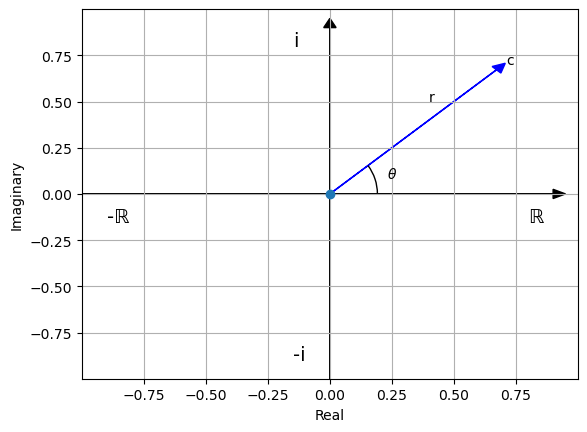

In [98]:
z=[0.7071 + 0.7071j] # 𝜃 = 𝜋/4

# params for AngleAnnotation func
center = (0, 0)
p1 = [(0, 0), (1.0, 0)]
p2 = [(0, 0), (1.0, 1.0)]
angle_size= 95

complex_plane2(z,p1,p2,angle_size,center,axis_type=1,angle_position="edge")
        
plt.ylabel('Imaginary')
plt.xlabel('Real')

plt.text(0.4,0.5,'r')
plt.text(0.71,0.70,'c')
plt.show()

In [99]:
display( Math('r = 1') )
display( Math('\\theta = \\frac {\\pi}{4}') )
display( Math('c = 𝑟(𝑐𝑜𝑠\\theta + 𝑖⋅sin\\theta) = 1(𝑐𝑜𝑠(\\frac{\\pi}{4}) + i⋅sin(\\frac{\\pi}{4})) = \
1(\\frac{\\sqrt{2}}{2} + i⋅\\frac{\\sqrt{2}}{2}) = 0.7071 + i⋅0.7071') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [100]:
display( Math('\\text{Validate using Pythagorean theorem:  } c = \\sqrt{a^2 + b^2 }') )
display( Math('r = \\sqrt{ (r \\cdot 𝑐𝑜𝑠\\theta)^2 + (r \\cdot sin\\theta)^2} = \
                \\sqrt{ (1 \\cdot 𝑐𝑜𝑠(\\frac {\\pi}{4}))^2 + (1 \\cdot sin(\\frac {\\pi}{4}))^2 } = \
                \\sqrt{ (1 \\cdot \\frac{\\sqrt{2}}{2})^2 + (1 \\cdot \\frac{\\sqrt{2}}{2})^2 } = \
                \\sqrt{ \\frac{1}{2} + \\frac{1}{2} } = 1' ) )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [101]:
display( Math('\\text{imaginary numbers rule:} \\: e^{i \\cdot \\pi \\cdot x} = (-1)^x') )
display( Math('e^{i \\cdot \\frac {\\pi}{4}} = e^{i \\cdot \\pi \\cdot \\frac {1}{4}} = (-1)^\\frac {1}{4} = \
               \\sqrt{-1}^4 = \\sqrt{i} =  0.7071 + i⋅0.7071') )
display( Math("\\text{Euler's formula: } e^{i\\theta} = cos \\theta + i \\cdot sin \\theta") )
display( Math('c = re^{i\\theta} = 1 \\cdot e^{i \\cdot \\frac {\\pi}{4}} = \
                𝑟(𝑐𝑜𝑠\\theta + 𝑖⋅sin\\theta) = 1(\\frac{\\sqrt{2}}{2} + i⋅\\frac{\\sqrt{2}}{2}) = 0.7071 + i⋅0.7071') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In Argand diagram (the representation of complex numbers in the complex plane), with the unit circle: 
$2\pi$ is a full circle and $\pi$ is half a circle ($180^\circ$).    
*i* is a rotation of $\frac{\pi}{2}$ radians ($\frac{1}{4}$ of a circle).     
Square root of a number on the Argand diagram, is dividing its rotation by 2.     
-1 is a rotation of $\pi$ radians.   
$\sqrt{-1}$ is a rotation of $\frac{\pi}{2}$ radians, which is *i*.    
So, $\sqrt{i}$ is the rotation of *i* divided by 2, which is $\frac{\pi}{4}$ radians.    
To locate it on the Argand diagram, we do: $cos(\frac{\pi}{4}) + i \cdot sin(\frac{\pi}{4})$ = 0.7071 + i⋅0.7071

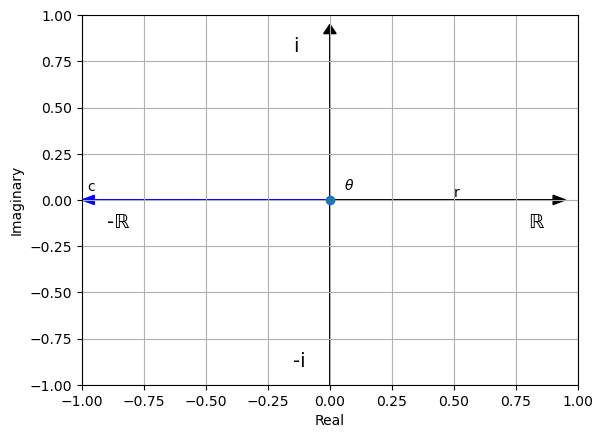

In [102]:
z=[-1+0j]  # 𝜃 = 𝜋

center = (0, 0)
p1 = [(0, 0), (1, 1)]
p2 = [(0, 0), (1, 1)]
angle_size= 35

complex_plane2(z,p1,p2,angle_size,center,axis_type=1,angle_position="edge")
        
plt.ylabel('Imaginary')
plt.xlabel('Real')

plt.text(0.5,0.02,'r')
plt.text(-0.98,0.05,'c')
plt.show()

In [103]:
display( Math('\\text{imaginary numbers rule:} \\: e^{i \\cdot \\pi \\cdot x} = (-1)^x') )
display( Math('e^{i \\cdot \\pi} = e^{i \\cdot \\pi \\cdot 1} = (-1)^1 = -1') )

display( Math('r = 1') )
display( Math('\\theta = \\pi') )
display( Math('c = re^{i\\theta} = 1 \\cdot e^{i \\cdot \\pi} = 1 \\cdot -1 = -1 = -1 + i \\cdot 0') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [104]:
display( Math('\\text{Validate using Pythagorean theorem:  } c = \\sqrt{a^2 + b^2 }') )
display( Math('r = \\sqrt{ (r \\cdot 𝑐𝑜𝑠\\theta)^2 + (r \\cdot sin\\theta)^2} = (1 \\cdot 𝑐𝑜𝑠(\\pi))^2 + (1 \\cdot sin(\\pi))^2 = (1 \\cdot (-1))^2 + (1 \\cdot 0)^2 = 1' ) )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

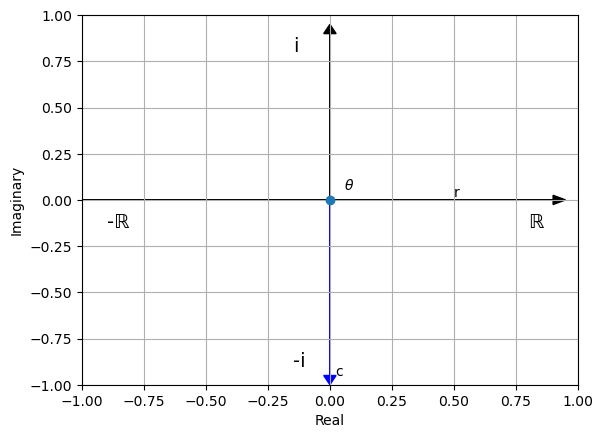

In [105]:
z=[0+ (-1j)]  # 𝜃 = 3𝜋/2

center = (0, 0)
p1 = [(0, 0), (1, 1)]
p2 = [(0, 0), (1, 1)]
angle_size= 35

complex_plane2(z,p1,p2,angle_size,center,axis_type=1,angle_position="edge")
        
plt.ylabel('Imaginary')
plt.xlabel('Real')

plt.text(0.5,0.02,'r')
plt.text(0.02,-0.95,'c')
plt.show()

In [106]:
display( Math('r = 1') )
display( Math('\\theta = 3\\frac{\\pi}{2}') )
display( Math('𝑐𝑜𝑠\\theta = 𝑐𝑜𝑠(3\\frac{\\pi}{2}) = 0') )
display( Math('sin\\theta = sin(3\\frac{\\pi}{2}) = -1') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [107]:
display( Math('e^{i \\cdot \\frac {3 \\cdot \\pi}{2}} = 𝑐𝑜𝑠(3\\frac{\\pi}{2}) + i \\cdot sin(3\\frac{\\pi}{2}) = 0 + i\\cdot(-1) = -i') )

<IPython.core.display.Math object>

In [108]:
display( Math('r = 1') )
display( Math('\\theta = \\frac {3 \\cdot \\pi}{2}') )
display( Math('c = re^{i\\theta} = 1 \\cdot e^{i \\cdot \\frac {3 \\cdot \\pi}{2}} = 1 \\cdot -i = -i = 0 + i \\cdot -1') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Complex conjugate

In [109]:
display( Math('\\text{complex conjugate operation:} \\quad i \\: \\longrightarrow \\: (-1) \\cdot i') )

<IPython.core.display.Math object>

In [110]:
display( Math('a,b \\in \\mathbb{R}') )
display( Math('c \\in \\mathbb{C}') )
display( Math('c = a+i \\cdot b') )
display( Math('c^* = a-i \\cdot b') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [111]:
display( Math('c = re^{i\\theta}') )
display( Math('c^* = re^{-i\\theta}') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Magnitude of a complex number
Magnitude represents length or size, and should be a Real non-negative number.

In [112]:
display( Math('\\text{Magnitude of a real number: }') )
display( Math('r \\in \\mathbb{R} \\rightarrow |r| \\in \\mathbb{R^+}') )
display( Math('|r| = \\sqrt{r^2}') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Magnitude should be a Real non-negative number.

In [113]:
display( Math('\\text{Magnitude of a complex number should also be a Real non-negative number: }') )
display( Math('c \\in \\mathbb{C} \\rightarrow |c| \\in \\mathbb{R^+}') )
display( Math('|c| = \\sqrt{c \\cdot c^*}') )
display( Math('|c|^2 = c \\cdot c^*') )
display( Math('c \\cdot c^* = (a + i \\cdot b)(a - i \\cdot b) = a^2 - i^2 \\cdot b^2 = a^2 - (-1) \
\\cdot b^2 = a^2 + b^2') )
display( Math('\{a^2 + b^2\} \\in \\mathbb{R} \\text{ non-negative}') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

##### Example:

In [114]:
display( Math('c = 3 + 4i') )
display( Math('|c| = \\sqrt{c \\cdot c^*} = \\sqrt{(3+4i)(3-4i)} = \\sqrt{9-12i + 12i - 16i^2} = \\sqrt{9 - (16i^2)} = \\sqrt{9 - (-16)} = \\sqrt{25} = 5') )
display( Math('|c|^2 = c \\cdot c^* = a^2 + b^2 = 3^2 + 4^2 = 25') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

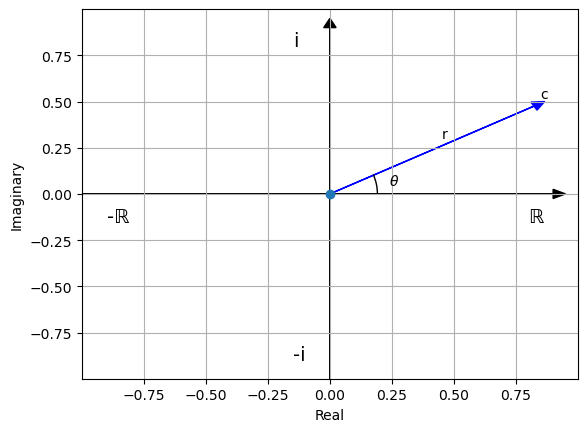

In [115]:
import matplotlib.pyplot as plt
import numpy as np # dodamo še numerično knjižico 
get_ipython().run_line_magic('matplotlib', 'inline')

# params for complex_plane2 func
z=[0.866+0.5j] # 𝜃 = 30

# params for AngleAnnotation func
center = (0, 0)
p1 = [(0, 0), (0, 0)]
p2 = [(0, 0), (0.3, 0.18)]
angle_size= 95

complex_plane2(z,p1,p2,angle_size,center,axis_type=1,angle_position="edge")
        
plt.ylabel('Imaginary')
plt.xlabel('Real')

plt.text(0.45,0.3,'r')
plt.text(0.85,0.52,'c')
plt.show()

The magnitude of a vector *c* is *r* which is the length of the *c* vector.

In [116]:
display( Math('|c| = \\sqrt{c \\cdot c^*}') )
display( Math('c = re^{i\\theta}') )
display( Math('c^* = re^{-i\\theta}') )
display( Math('|c| = |re^{i\\theta}| = \\sqrt{re^{i\\theta} \\cdot re^{-i\\theta}} = \
\\sqrt{r^2e^{i(\\theta - \\theta)}} = \\sqrt{r^2e^{i \\cdot 0}} = \\sqrt{r^2} = |r|') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Dirac notation

In [117]:
display( Math('| \\psi \\rangle \\: , \\: \langle \\psi |') )

<IPython.core.display.Math object>

In [118]:
v= np.array(['𝜓_1','𝜓_2','𝜓_3','𝜓_d'])
display( Math('| \\psi \\rangle \\text{  - ket, represents a column vector } ') )
v.shape = (4,1)
display( Math('| \\psi \\rangle = ' + sym.latex(sym.sympify(v)) + '\\in \\mathbb{C^d}') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [119]:
display( Math('\langle \\psi | \\text{  - bra, represents a row vector } ') )
v.shape = (1,4)
display( Math('\langle \\psi | = ' + sym.latex(sym.sympify(v)) + '\\in \\mathbb{C^d}') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [120]:
v0= np.array([1,0,0,0,0])
v1= np.array([0,1,0,0,0])
vd= np.array([0,0,0,0,1])
v0.shape = (5,1)
v1.shape = (5,1)
vd.shape = (5,1)
display( Math('| 0 \\rangle = ' + sym.latex(sym.sympify(v0)) + '\\in \\mathbb{C^d} \\quad \\quad \
| 1 \\rangle = ' + sym.latex(sym.sympify(v1)) + '\\in \\mathbb{C^d} \\quad \\quad \
| d-1 \\rangle = ' + sym.latex(sym.sympify(vd)) + '\\in \\mathbb{C^d}') )

<IPython.core.display.Math object>

## Conjugate Transpose

Congugate transpose of a matrix or a vector: 
1. Perfrom complex congugate (star) on each of the entries in the matrix (vector)
2. Transpose the whole matrix (vector): flip the matrix (vector) about its diagonal.  
Transpose of a column vector results in a row vector and vice versa.

In [121]:
v= np.array(['𝜓_1','𝜓_2','𝜓_3','𝜓_d'])
v.shape = (4,1)
display( Math('\\big| \\psi \\rangle = ' + sym.latex(sym.sympify(v)) + '\\in \\mathbb{C^d}') )

v_ct= np.array(['𝜓_1^*','𝜓_2^*','𝜓_3^*','𝜓_d^*'])
display( Math('(\\; \\big| \\psi \\rangle ^*)^T = \langle \\psi \\big| = [𝜓_1^* \\; 𝜓_2^* \\; 𝜓_3^* \\; 𝜓_4^* \\: ... \\: 𝜓_d^*] '))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Inner product
#### How similar two vectors are
An inner product of two vectors is the overlap between the two vectors (the projection of one onto the other).

In [122]:
v_theta= np.array(['𝜃_1','𝜃_2','𝜃_3','𝜃_d'])
v_theta.shape = (4,1)
display( Math('\langle \\psi | \\theta \\rangle = \sum_{i=1}^{d} (\\psi_i^*) \\cdot \\theta_i = \
                [𝜓_1^* \\; 𝜓_2^* \\; 𝜓_3^* \\; 𝜓_4^* \\: ... \\: 𝜓_d^*] \\cdot'\
                + sym.latex(sym.sympify(v_theta)) + ' = c \\in \\mathbb{C}') )

<IPython.core.display.Math object>

In [123]:
display( Math('\langle \\psi | \\theta \\rangle = \langle \\theta | \\psi \\rangle^*') )
display( Math('\langle \\psi | \\theta \\rangle \\in \\mathbb{C}') )
display( Math('\langle \\theta | \\psi \\rangle^* \\in \\mathbb{C}') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

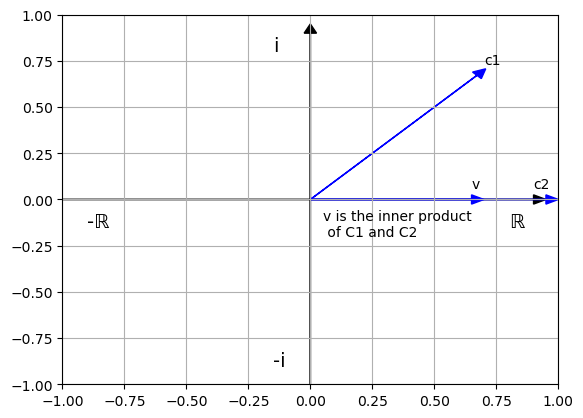

In [124]:
z2=[1+0j,0.7071 + 0.7071j, 0.7 + 0.0j] # 0, 𝜋/4
complex_plane2(z2, axis_type=1)

plt.text(0.7,0.73,'c1')
plt.text(0.9,0.06,'c2')
plt.text(0.65,0.06,'v')
plt.text(0.05,-0.2,'v is the inner product \n of C1 and C2')
plt.show()

The Inner product (v) is the measurement of the overlap of these two vectors (c1 and c2).  
This is the projection of c1 onto c2.  
Measures how close, or similar, the two vectors are.   

## Euclidean norm
#### Length of a vector
The overlap of a vector with itself, a non negative real number.

In [125]:
display( Math('\\text{As we computed the length of a complex number: }|c| = \\sqrt{c \\cdot c^*}') )

<IPython.core.display.Math object>

To get the magnitude of complex numbers, we multiply the complex number with its complex conjugate and take the square-root (to get rid of the square).  
To get the magnitude of a vector we do the same thing: we multiply the vector with its conjugate transpose and take the square-root.  
The output is a non-negative Real number.  
This is also called the 2-norm of a vector.

In [126]:
display( Math('\\big|\\big| \\: | \\psi \\rangle \\: \\big|\\big|_2 = \\sqrt {\langle \\psi | \\psi \\rangle}') )

<IPython.core.display.Math object>

In [127]:
print('\nExample using a unit vector:\nAn inner product of a vector with itself (the overlap with itself).')
print('The norm (length) of a unit vector is 1.\n')
display( Math('\\frac {1}{\\sqrt{2}} \\text{ is a normalization factor}') )
v3= np.array([1,'i'])
v4= np.array([1,'-i'])

v3.shape = (2,1)
v4.shape = (1,2)

display( Math('| \\psi \\rangle = \\frac {1}{\\sqrt{2}}' + sym.latex(sym.sympify(v3)) + '\\in \\mathbb{C^2}') )
display( Math('\\langle \\psi | = (| \\psi \\rangle^*)^T = \\frac {1}{\\sqrt{2}}' + sym.latex(sym.sympify(v4)) + '\\in \\mathbb{C^2}') )

display( Math('\\big|\\big| \\: | \\psi \\rangle \\: \\big|\\big|_2 = \\sqrt {\langle \\psi | \\psi \\rangle} = \
\\sqrt {\\frac {1}{\\sqrt{2}}(' + sym.latex(sym.sympify(v4)) + ') \\cdot \\frac {1}{\\sqrt{2}}(' + sym.latex(sym.sympify(v3)) + ')} \
 = \\frac {1}{\\sqrt{2}} \\sqrt{1 + (-i)i} = \\frac {1}{\\sqrt{2}} \\sqrt{1 + (-(i^2)} = \\frac {1}{\\sqrt{2}} \\sqrt{1 + (-(-1)} = \
 \\frac {1}{\\sqrt{2}} \\sqrt{2} = 1') )


Example using a unit vector:
An inner product of a vector with itself (the overlap with itself).
The norm (length) of a unit vector is 1.



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Distance using Euclidean norm
How well can we distinguish two quantum states (represented by vectors).  
(e.g., when we want a state that represents a correct answer to be very distinguished than states that represent wrong answers)  
40:00

In [128]:
display( Math('\\text{The Euclidean distance between}\\:| \\psi \\rangle , | \\theta \\rangle \\in \\mathbb{C^d} \\:\\: \
is \\:\\: \\big|\\big| \\: | \\psi \\rangle - | \\theta \\rangle \\: \\big|\\big|_2 \\in \\mathbb{C^d}') )

<IPython.core.display.Math object>

Euclidean norm properties:

In [129]:
display( Math('\\underline{\\text{1. Positive scalability:}}') )
display( Math('|ab| = |a|\\cdot|b|') )
display( Math('c \\in \\mathbb{C}') )
display( Math('\\big|\\big| \\: c \\cdot | \\psi \\rangle \\: \\big|\\big|_2 = |c| \\: \\cdot \\: \
\\big|\\big| \\: | \\psi \\rangle \\: \\big|\\big|_2') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [130]:
display( Math('\\underline{\\text{2. Triangle inequality:}}') )
display( Math('\\forall \\; (\\;| \\psi \\rangle , | \\theta \\rangle \\in \\mathbb{C^d}\\;) \\:,\\: \
\\big|\\big| \\: | \\psi \\rangle + | \\theta \\rangle \\: \\big|\\big|_2 \\:\\:\\le\\:\\: \\big|\\big| \\: | \\psi \\rangle \\: \\big|\\big|_2 \\:+\\: \
\\big|\\big| \\: | \\theta \\rangle \\: \\big|\\big|_2') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

This just saying that the direct route represnts by |𝜓⟩+|𝜃⟩ , in the picture below,   
is never longer than the route (distance) along the two vectors |𝜓⟩ and |𝜃⟩

<div> <img src="triangle_inequality.png" alt="Triangle inequality" style="width: 300px;"/></div> 

In [131]:
display( Math('\\underline{\\text{3. The norm of any vector is always non-negative:}}') )
display( Math('\\forall | \\psi \\rangle \\in \\mathbb{C^d} \\:,\\: \
\\big|\\big| \\: | \\psi \\rangle \\: \\big|\\big|_2 \\:\\:\\ge\\:\\: 0') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Orthonormal bases
https://www.youtube.com/watch?v=lNTk9_WKvnk&list=PLZGjbQcY0aI4PB63hH_RnfnJSfNK1OojC&index=3  
47:47

In [132]:
display( Math('\{| \\psi \\rangle _i \} \subseteq \\mathbb{C^d} \\:\\: \\text{, is an } \\underline{orthogonal} \
\\: \\text{set if:} \
\\quad \\forall (i \\neq j) \\:, \\langle \\psi _i| \\psi _j \\rangle = 0') )

<IPython.core.display.Math object>

In [133]:
display( Math('\{| \\psi \\rangle _i \} \subseteq \\mathbb{C^d} \\:\\: \\text{, is an } \\underline{orthonormal} \
\\: \\text{set if:} \
\\quad \\forall (i,j) \\:, \\langle \\psi _i| \\psi _j \\rangle = \\delta_{i j}') )

<IPython.core.display.Math object>

Kronecker Delta:
$\quad \delta_{i j} := $
$\left\{ 
  \begin{array}{ c l }
    1 & \: \textrm{if } i = j \\
    0                 & \: \textrm{if }  i \neq j
  \end{array}
\right.$

The inner product of a vector with itself is 1, which means that this is a set of unit vectors.   
The inner product between two different vectors is 0, which means that this is a set of vectors that are orthogonal to each other .   
A set of vectors that are both, unit vectors and are orthogonal to each other, is a set of **orthonormal** vectors.

## Computational or Standard basis

In [134]:
v0= np.array([1,0])
v1= np.array([0,1])
v0.shape = (2,1)
v1.shape = (2,1)
display( Math('| 0 \\rangle = ' + sym.latex(sym.sympify(v0)) + '\\in \\mathbb{C^2}') )
display( Math('| 1 \\rangle = ' + sym.latex(sym.sympify(v1)) + '\\in \\mathbb{C^2}') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

These are orthonormal basis vectors

In [135]:
display( Math('\\forall \\; | \\psi \\rangle \\in \\mathbb{C^2} \\:, \\: | \\psi \\rangle = \
\\alpha | 0 \\rangle + \\beta | 1 \\rangle') )

<IPython.core.display.Math object>

In [136]:
display( Math('\\text{The vectors are normalized if:} \\: \\big|\\big| \\: | \\psi \\rangle \\: \\big|\\big|_2 = 1') )
display( Math('\\big|\\big| \\: | \\psi \\rangle \\: \\big|\\big|_2 = \\sqrt {\langle \\psi | \\psi \\rangle}') )
display( Math('= \\sqrt {\\;(\\; \\alpha^* \\langle 0 | + \\beta^* \\langle 1 |\\; ) \\cdot (\\; \\alpha | 0 \\rangle + \
\\beta | 1 \\rangle \\;)} ') )
display( Math('= \\sqrt {\\;\\alpha^*\\alpha \\langle 0 |0 \\rangle + \
                \\alpha^*\\beta \\langle 0 |1 \\rangle + \\alpha \\beta^* \\langle 1 |0 \\rangle + \
                \\beta \\beta^* \\langle 1 |1 \\rangle}') )
display( Math('= \\sqrt{ \\;|\\alpha|^2 \\cdot 1 + 0 + 0 + |\\beta|^2 \\cdot 1}') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [137]:
display( Math("\\text{We used above the following equation from 'magnitude':} \\quad |\\alpha|^2 = \\alpha \\cdot \\alpha^*") )

<IPython.core.display.Math object>

## Linear Maps and Matrices
https://www.youtube.com/watch?v=lNTk9_WKvnk&list=PLZGjbQcY0aI4PB63hH_RnfnJSfNK1OojC&index=3   
1:00:00

In [138]:
display( Math(' \\Phi: \\mathbb{C^d} \\longrightarrow \\mathbb{C^k} \\text{ is linear if } \\: \\forall(\\;| \\psi \\rangle = \
\sum_{i} \\alpha_i \\cdot | \\psi_i \\rangle\\;)\\;,\\; \
\\Phi(| \\psi \\rangle) = \\Phi(\sum_{i} \\alpha_i \\cdot | \\psi_i \\rangle\\;) = \sum_{i}\\alpha_i \\cdot \\Phi(| \\psi_i \\rangle)') )

<IPython.core.display.Math object>

In [139]:
display( Math('\\text{Notation:}'))
display( Math('\\mathcal{L}(X,Y): \\: \\text{Set of linear maps from X to Y}') )
display( Math('\\mathcal{L}(X,X) = \\mathcal{L}(X)') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [140]:
display( Math('\\text{Example:}'))
display( Math('\\mathcal{L}(\\mathbb{C^2},\\mathbb{C^2}): \\quad \\Phi: \\mathbb{C^2} \\longrightarrow \\mathbb{C^2}') )
display( Math('\\Phi(\\;| 0 \\rangle\\;) = | 1 \\rangle \\:,\\: \\Phi(\\;| 1 \\rangle\\;) = | 0 \\rangle \
                \\quad \\longrightarrow \\quad (\\text{the quantum NOT gate})') )
display( Math('\\Phi(\\; \\alpha \\cdot | 0 \\rangle + \\beta \\cdot | 1 \\rangle \\;) =\
                \\alpha \\cdot \\Phi(\\;| 0 \\rangle\\;) + \\beta \\cdot \\Phi(\\;| 1 \\rangle\\;) = \
                \\alpha \\cdot | 1 \\rangle + \\beta \\cdot | 0 \\rangle') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Representation of linear maps via matrices

In [141]:
display( Math('\\Phi: \\mathbb{C^2} \\longrightarrow \\mathbb{C^2}') )
display( Math('\\biggr[ \\quad \\Phi(\\;| 0 \\rangle\\;) \\quad \\Phi(\\;| 1 \\rangle\\;) \\quad \\Phi(\\;| 2 \\rangle\\;) \
                \\quad . \\: . \\: . \\quad \\Phi(\\;| d-1 \\rangle\\;) \\quad \\biggr]') )
display( Math('\\text{According to the place in order. The first is the action of phi on the base vector 0, the second is the action of phi on the base vector 1,}') ) 
display( Math('\\text{... and the last is the action of phi on the base vector d-1}') )

va= np.array(['a','b','...','d'])
vb= np.array(['a','b','...','d'])
vc= np.array(['a','b','...','d'])
vd= np.array(['a','b','...','d'])
va.shape = (4,1)
vb.shape = (4,1)
vc.shape = (4,1)
vd.shape = (4,1)
display( Math('A = \\Biggr[\\quad' + sym.latex(sym.sympify(va)) + '\\quad \\:' + sym.latex(sym.sympify(vb)) + '\\quad \\:' \
              + sym.latex(sym.sympify(vc)) + '\\quad . \\: . \\: . \\quad \\:' + sym.latex(sym.sympify(vd)) + '\\quad \\Biggr]\
              \\quad \\longrightarrow \\quad \\text{d x d matrix}' ) )
display( Math('\\text{d x d complex matrix A is 2d array of complex numbers}') )
display( Math('A_{i,j} \\in \\mathbb{C}') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [142]:
display( Math('\\underline{Example:}') )
display( Math('\\text{The quantum NOT gate (X gate)}') )
display( Math('\\Phi(\\;| 0 \\rangle\\;) = | 1 \\rangle') )
display( Math('\\Phi(\\;| 1 \\rangle\\;) = | 0 \\rangle') )
display( Math('A = \\Biggr[ \\quad \\Phi(\\;| 0 \\rangle\\;) \\quad \\Phi(\\;| 1 \\rangle\\;) \\quad \\Biggr] \
                = \\Biggr[ \\quad | 1 \\rangle \\quad | 0 \\rangle \\quad \\Biggr] \
                = \\begin{bmatrix}0 & 1\\\\ 1 & 0 \\end{bmatrix} =: X') )
display( Math('\\text{According to the place in order. The first is the action of phi on the base vector 0, the second is the action of phi on the base vector 1.}') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [143]:
display( Math('\\underline{Example:}') )
display( Math('\\text{What is the linear map that represented by the Identity matrix}') )
display( Math('I = \\begin{bmatrix}1 & 0\\\\ 0 & 1 \\end{bmatrix} \
                = \\Biggr[ \\quad \\Phi(\\;| 0 \\rangle\\;) \\quad \\Phi(\\;| 1 \\rangle\\;) \\quad \\Biggr]') )
display( Math('\\text{So, what does this matrix do?}') )
display( Math('\\Phi(\\;| 0 \\rangle\\;) = | 0 \\rangle') )
display( Math("\\text{The first column is phi of 0, and it it just 0 in the matrix!, it hasn't done anything.}") )
display( Math('\\Phi(\\;| 1 \\rangle\\;) = | 1 \\rangle') )
display( Math("\\text{The second column is phi of 1, and it it just 1 in the matrix!, so, it hasn't done anything as well.}") )
display( Math('\\text{This map not doing anything. it maps 0 to 0, and 1 to 1}') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Matrix multiplication
https://www.youtube.com/watch?v=lNTk9_WKvnk&list=PLZGjbQcY0aI4PB63hH_RnfnJSfNK1OojC&index=3     
at 1:17:00

In [144]:
display( Math('A,B \\in \\mathcal{L}(\\mathbb{C^d})') )
display( Math('C_{i,j} = AB_{(i,j)} = \sum_{k=1}^d A_{(i,k)}B_{(k,j)}') )

print()
display( Math('\\underline{Example:}') )
print()

display( Math('A = \\begin{bmatrix}3 & 7\\\\ 4 & 9 \\end{bmatrix} \\quad , \\quad \
               B = \\begin{bmatrix}6 & 2\\\\ 5 & 8 \\end{bmatrix}') )

display( Math('AB_{11} = 3 \\cdot 6 + 7 \\cdot 5 = 53 \\quad AB_{12} = 3 \\cdot 2 + 7 \\cdot 8 = 62') )
display( Math('AB_{21} = 4 \\cdot 6 + 9 \\cdot 5 = 69 \\quad AB_{22} = 4 \\cdot 2 + 9 \\cdot 8 = 80') )

display( Math('AB = \\begin{bmatrix}53 & 62\\\\ 69 & 80 \\end{bmatrix}') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Matrices are not commutative in general

In [145]:
display( Math('A \\cdot B \\neq B \\cdot A') )

display( Math('\\underline{Example:}') )
print()

display( Math('X = \\begin{bmatrix}0 & 1\\\\ 1 & 0 \\end{bmatrix} \\quad , \\quad \
               Z = \\begin{bmatrix}1 & 0\\\\ 0 & -1 \\end{bmatrix}') )

display( Math('X \\cdot Z \\neq Z \\cdot X') )

display( Math('\\href{https://en.wikipedia.org/wiki/Commutator}{Commutator} \\: \\rightarrow \\: [X,Z] \\: := \\: XZ - ZX \\neq 0') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Image of map

In [183]:
display( Math('\\text{Apply a linear-map (matrix) to a preimage item to get its image.}') )
display( Math('\\text{Map a preimage to an image.}') )
print()
display( Math('\\text{Im}(A) := \\Bigl\{ \\: | \\psi \\rangle \\in \\mathbb{C^d} \\:\\: \\Big| \\quad | \\psi \\rangle = A \\cdot \
                | \\phi \\rangle \\quad \\text{for some} \\quad | \\phi \\rangle \\in \\mathbb{C^d} \\: \\Bigl\}') )
display( Math('| \\psi \\rangle \\rightarrow \\text{Image, the Set of} \\: \\underline{all} \\: \
                \\text{outputs, the output space (a vector space) of the map} \\; A') )
display( Math('| \\phi \\rangle \\rightarrow \\text{Preimage, the Set of} \\: \\underline{some} \\: \\text{inputs}') )

print()

display( Math('\\text{Rank: the dimention of the output space (the Set of the output vectors)}') )
display( Math('rank(A) = dim(\\;\\text{Im}(A)\\;) \\quad \\quad (dim = dimention)') )
display( Math('\\text{If} \\; rank(A) = d, \\quad \\text{then} \\:\\: \\text{Im}(A) = \\mathbb{C^d}') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

https://www.youtube.com/watch?v=lNTk9_WKvnk&list=PLZGjbQcY0aI4PB63hH_RnfnJSfNK1OojC&index=3     
at 1:27:00

In [185]:
display( Math('\\underline{\\text{Null space (A)}}') )
display( Math("\\text{The complement of the map's image.}") )
display( Math("\\text{The set of all vectors that this map sends to the scalar zero (kill)}") )
display( Math('Null(A) := \\big\{\\:| \\psi \\rangle \\in \\mathbb{C^d} \\quad \\big| \\quad A \\cdot | \\psi \\rangle = 0 \\: \\big\}') )
display( Math('rank(A) + dim(Null(A)) = d \\quad \\longrightarrow \\quad (\\text{the full dimention } \\textit{d}, \
                \\text{the dimention of the entire space})') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [192]:
display( Math('\\underline{Example:}') )
display( Math('B = \\begin{bmatrix}1 & 0\\\\ 0 & 0 \\end{bmatrix}') )
display( Math('\\text{What is the null space of the linear map that represented by the B matrix? What is Null(B)?}') )
display( Math('\\text{B multiply by some State:}') )
display( Math('B \\cdot \\big(\\; \\alpha \\cdot | 0 \\rangle + \\beta \\cdot | 1 \\rangle \\;\\big) =\
                \\begin{bmatrix}1 & 0\\\\ 0 & 0 \\end{bmatrix} \\cdot \
                \\begin{bmatrix} \\alpha \\\\ \\beta \\end{bmatrix} = \
                \\begin{bmatrix} 1\\cdot\\alpha + 0\\cdot\\beta \\\\ 0\\cdot\\alpha + 0\\cdot\\beta \\end{bmatrix} = \
                \\begin{bmatrix} \\alpha \\\\ 0 \\end{bmatrix}') )
display( Math("\\text{B kills off the second coordinate for any input vector it gets.}") )
display( Math("\\text{And thus, B will send to zero, every vector that has its alpha equal to 0.}") )
display( Math("\\text{The Image space of B is the }Span\\biggl\{\\begin{bmatrix} 1 \\\\ 0 \\end{bmatrix}\\biggl\} \
                \\quad \\longrightarrow \\quad dim = 1 \\: \\rightarrow \\: (\\text{the rank of B is the span of one vector})") )
display( Math("\\text{The Null space of B is the }Span\\biggl\{\\begin{bmatrix} 0 \\\\ 1 \\end{bmatrix}\\biggl\} \
                \\quad \\longrightarrow \\quad dim = 1") )

display( Math('d = rank(B) + dim(Null(B)) = \\textit{2} \\quad \\longrightarrow \\quad (\\text{the full dimention } \\textit{d}, \
                \\text{the dimention of the entire space})') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Matrix (linear maps) operations
https://www.youtube.com/watch?v=lNTk9_WKvnk&list=PLZGjbQcY0aI4PB63hH_RnfnJSfNK1OojC&index=3     
at 1:33:00

In [208]:
display( Math('\\underline{\\text{3 Linear maps:}} \\quad A^* \\:,\\: A^T  \\:,\\: A^\\dagger') )
display( Math('A^*_{(i,j)} = (A_{(i,j)})^*\\: \\rightarrow \\: \\text{Entry-wise complex conjugate}') )
display( Math('A^T_{(i,j)} = A_{(j,i)}\\: \\rightarrow \\: \\text{Transpose}') )
display( Math('A^\\dagger = (A^*)^T \\: \\rightarrow \\: \\text{Dagger or Adjoint or Hermitian conjugate}') )
print()
display( Math('\\text{Properties:}') )
display( Math('(AB)^T = B^TA^T') )
display( Math('(AB)^\\dagger = B^\\dagger A^\\dagger') )
display( Math('\\big| \\psi \\rangle ^\\dagger = \\langle \\psi \\big| ') )

print()
display( Math('\\underline{Example:}') )

display( Math('A = \\begin{bmatrix}1 & 2\\\\ 3 & e^{i\\frac{\\pi}{2}} \\end{bmatrix} \\quad , \\quad \
               A^\\dagger = \\begin{bmatrix}1 & 3\\\\ 2 & e^{-i\\frac{\\pi}{2}} \\end{bmatrix}') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [236]:
display( Math('\\underline{\\text{The Trace map}}') )
display( Math('\\text{Adds the terms in the diagonal of the matrix}') )
display( Math('Tr: \\: \\mathcal{L}\\big(\\mathbb{C^d}\\big) \\longrightarrow \\mathbb{C^d}') )
display( Math('Tr\\;\\big(A\\big) = \sum_{i=1}^d A_{(i,i)}') )
display( Math('A = \\begin{bmatrix}a & b & c \\\\ d & f & g \\\\ h & i & j \\end{bmatrix} \\quad \\quad \
                Tr\\;\\big(A\\big) = a + f + j') )
print()
display( Math('\\text{Properties:}') )
display( Math('\\underline{\\text{Trace is Cyclic:}}') )
display( Math('Tr\\;\\big(A \\cdot B \\cdot C\\big) = Tr\\;\\big(B \\cdot C \\cdot A\\big)') )
print()
display( Math('Tr\\;\\big(AB\\big) = Tr\\;\\big(BA\\big) \\quad \\text{( Even if}\\: AB \\neq BA \\:)') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# ==========================================================